In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from config import Config as c

In [2]:
import matplotlib.pyplot as plt
import json
import pandas as pd

In [56]:
import os
import random
from pathlib import Path
import shutil

In [86]:
ham_dataset_dir = 'ham_minified'
nv_source_dir = 'nv_src'
nv_test_num = 200
nv_gen_num = 100
batch_size = 48
seed = 42

In [44]:
IMG_SIZE = (224, 224)

In [45]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data Preprocessing and Augmentation

In [7]:
# images = list(os.walk(ham_dataset_dir + '/nv'))[0][2]
# images_to_save = random.sample(images, nv_test_num)
# images_to_delete = [image for image in images if image not in images_to_save]
# for image_to_delete in images_to_delete:
#     path = Path(f'{ham_dataset_dir}/nv/{image_to_delete}')
#     path.unlink(missing_ok=False)

In [84]:
images = list(os.walk(ham_dataset_dir + '/nv'))[0][2]
for image_to_delete in images:
    path = Path(f'{ham_dataset_dir}/nv/{image_to_delete}')
    path.unlink(missing_ok=False)

In [88]:
images = list(os.walk(nv_source_dir + '/nv_true'))[0][2]
nv_images = random.sample(images, nv_test_num)
for true_image in nv_images:
    shutil.move(nv_source_dir + '/nv_true/' + true_image, ham_dataset_dir + '/nv/' + true_image)

In [89]:
images = list(os.walk(nv_source_dir + '/gen_data'))[0][2]
gen_images = random.sample(images, nv_gen_num)
for gen_image in gen_images:
    shutil.move(nv_source_dir + '/gen_data/' + gen_image, ham_dataset_dir + '/nv/' + gen_image)

In [90]:
train_ds = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.3, color_mode='rgb',
                                                            labels='inferred', label_mode='categorical', shuffle=True, subset='training', image_size=IMG_SIZE,
                                                            batch_size=batch_size, seed=seed)

val_ds = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.3, color_mode='rgb',
                                                          labels='inferred', label_mode='categorical', shuffle=True, subset='validation', image_size=IMG_SIZE,
                                                          batch_size=batch_size,  seed=seed)

Found 3026 files belonging to 4 classes.
Using 2119 files for training.
Found 3026 files belonging to 4 classes.
Using 907 files for validation.


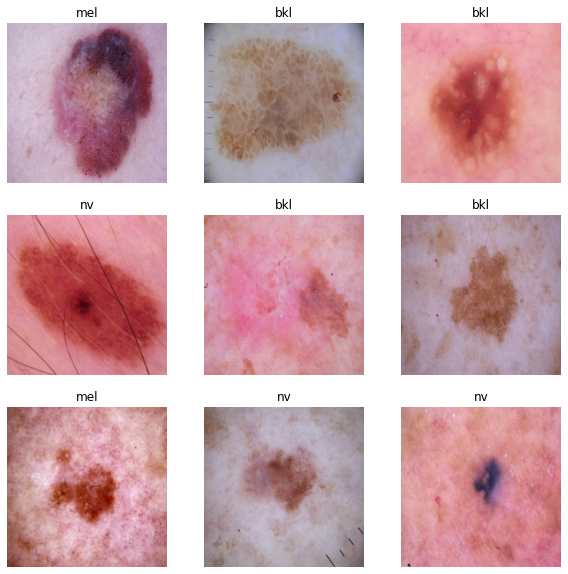

In [424]:
# class_names = train_ds.class_names

# plt.figure(figsize=(10, 10))

# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

In [91]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [92]:
val_labels = [np.argmax(y.numpy(), axis=1) for x, y in list(val_ds)]
val_labels = np.concatenate(val_labels, axis=None)

test_labels = [np.argmax(y.numpy(), axis=1) for x, y in list(test_ds)]
test_labels = np.concatenate(test_labels, axis=None)

In [93]:
print('Size of validation dataset: %d' % len(val_labels))
print('Size of test dataset: %d' % len(test_labels))

Size of validation dataset: 475
Size of test dataset: 432


In [94]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 10
Number of test batches: 9


In [95]:
# train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# val_ds = val_ds.map(lambda x, y: (rescale(x), y))
# test_ds = test_ds.map(lambda x, y: (rescale(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### Data Augmentation

In [96]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.RandomZoom(0.4,0.4),
  tf.keras.layers.RandomContrast(0.3)
])

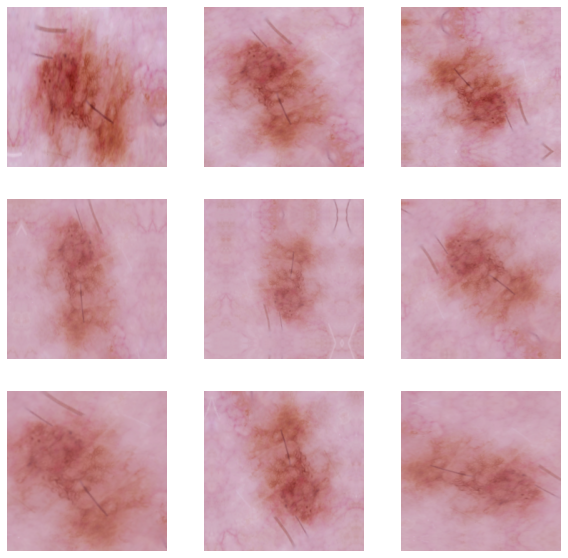

In [19]:
# for image, _ in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = image[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#         plt.imshow(augmented_image[0] / 255)
#         plt.axis('off')

In [17]:
# rescale = keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)

### Define Model

In [97]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [98]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(48, 7, 7, 2048)


In [99]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [100]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(48, 2048)


In [101]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(48, 4)


In [102]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [103]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [721]:
# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.categorical_crossentropy,
#               metrics=['accuracy'])

### Fine-Tune Model

In [104]:
# Make bottom layers trainable
base_model.trainable = True

In [105]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [106]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [107]:
# model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [108]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

In [109]:
len(model.trainable_variables)

92

### Model Training

In [110]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(val_ds)

10/10 [==============================] - 3s 155ms/step - loss: 1.5342 - accuracy: 0.3453


In [111]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.53
initial accuracy: 0.35


In [112]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/50
45/45 [==============================] - 15s 245ms/step - loss: 1.1395 - accuracy: 0.4861 - val_loss: 0.9266 - val_accuracy: 0.6232
Epoch 2/50
45/45 [==============================] - 11s 231ms/step - loss: 0.9176 - accuracy: 0.6069 - val_loss: 0.8601 - val_accuracy: 0.6505
Epoch 3/50
45/45 [==============================] - 11s 230ms/step - loss: 0.7881 - accuracy: 0.6730 - val_loss: 0.9029 - val_accuracy: 0.6126
Epoch 4/50
45/45 [==============================] - 11s 232ms/step - loss: 0.7609 - accuracy: 0.6852 - val_loss: 0.8921 - val_accuracy: 0.6716
Epoch 5/50
45/45 [==============================] - 11s 233ms/step - loss: 0.7002 - accuracy: 0.7069 - val_loss: 0.9200 - val_accuracy: 0.6589
Epoch 6/50
45/45 [==============================] - 11s 232ms/step - loss: 0.6676 - accuracy: 0.7239 - val_loss: 0.7825 - val_accuracy: 0.7200
Epoch 7/50
45/45 [==============================] - 10s 230ms/step - loss: 0.6096 - accuracy: 0.7560 - val_loss: 0.7806 - val_accuracy: 0.7242

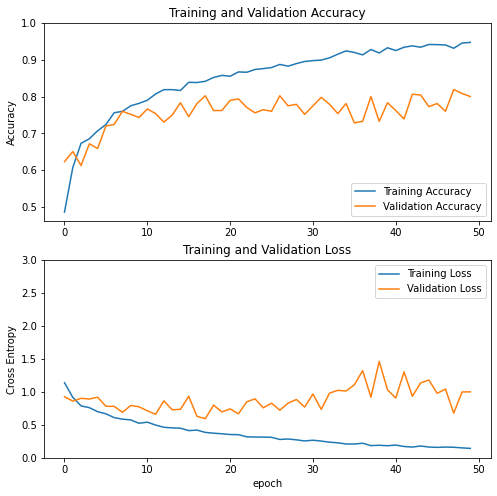

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('plots/da_ft_history_nv_' + str(nv_test_num) + '_gen_' + str(nv_gen_num) + '.pdf')

In [32]:
plt.show()

In [115]:
with open('history/da_ft_history_nv_' + str(nv_test_num) + '_gen_' + str(nv_gen_num) + '.json', 'w') as f:
        json.dump(history.history, f, indent=4)

### Evaluation, Test Set

In [116]:
test_list = list(test_ds)

In [117]:
preds = []
labels = []

for batch_num in range(len(test_list)):
    image_batch, label_batch = test_list[batch_num]
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()
    this_pred = model.predict_on_batch(image_batch)
    this_classes = np.argmax(this_pred, axis=1)
    
    pred = tf.keras.utils.to_categorical(this_classes, num_classes=4)
    
    y_test_non_category = [ np.argmax(t) for t in label_batch ]
    y_predict_non_category = [ np.argmax(t) for t in pred ]
    
    labels.extend(y_test_non_category)
    preds.extend(y_predict_non_category)

In [118]:
label_names = sorted(os.listdir(ham_dataset_dir))

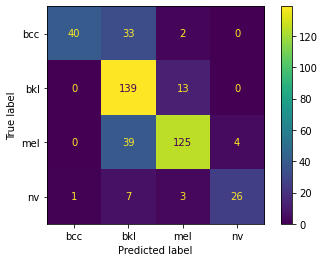

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mat = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=label_names)
disp.plot()
plt.savefig('plots/da_ft_confmat_nv_' + str(nv_test_num) + '_gen_' + str(nv_gen_num) + '.pdf')

In [120]:
plt.show()

In [121]:
print("Model tested on a total of {} images".format(len(labels)))

Model tested on a total of 432 images


### Precision Recall Metrics

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [41]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels, preds)))

print('Micro Precision: {:.2f}'.format(precision_score(labels, preds, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(labels, preds, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(labels, preds, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(labels, preds, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(labels, preds, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(labels, preds, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(labels, preds, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(labels, preds, target_names=label_names))


Accuracy: 0.82

Micro Precision: 0.82
Micro Recall: 0.82
Micro F1-score: 0.82

Macro Precision: 0.85
Macro Recall: 0.76
Macro F1-score: 0.79

Weighted Precision: 0.83
Weighted Recall: 0.82
Weighted F1-score: 0.82

Classification Report

              precision    recall  f1-score   support

         bcc       0.95      0.74      0.83        77
         bkl       0.80      0.87      0.83       160
         mel       0.80      0.87      0.84       163
          nv       0.86      0.56      0.68        32

    accuracy                           0.82       432
   macro avg       0.85      0.76      0.79       432
weighted avg       0.83      0.82      0.82       432



In [122]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels, preds)))

print('Micro Precision: {:.2f}'.format(precision_score(labels, preds, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(labels, preds, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(labels, preds, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(labels, preds, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(labels, preds, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(labels, preds, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(labels, preds, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(labels, preds, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(labels, preds, target_names=label_names))


Accuracy: 0.76

Micro Precision: 0.76
Micro Recall: 0.76
Micro F1-score: 0.76

Macro Precision: 0.84
Macro Recall: 0.72
Macro F1-score: 0.76

Weighted Precision: 0.81
Weighted Recall: 0.76
Weighted F1-score: 0.76

Classification Report

              precision    recall  f1-score   support

         bcc       0.98      0.53      0.69        75
         bkl       0.64      0.91      0.75       152
         mel       0.87      0.74      0.80       168
          nv       0.87      0.70      0.78        37

    accuracy                           0.76       432
   macro avg       0.84      0.72      0.76       432
weighted avg       0.81      0.76      0.76       432



In [42]:
report_dict = classification_report(labels, preds, target_names=label_names, output_dict=True)
report_data = pd.DataFrame(report_dict)
report_data.to_csv('reports/da_ft_report_nv_'+ str(nv_test_num) + '_gen_' + str(nv_gen_num) + '.csv')

In [739]:
report_nv200_gen100 = pd.read_csv('reports/report_nv_100')

In [ ]:
print(report_nv_200_gen_100)

### Class Weight Stuff

In [9]:
class_weights = {}
for i in range(len(class_weights_list)):
    class_weights[i] = class_weights_list[i]

In [5]:
classes = train_ds.class_names
train_ds_single_batch = keras.preprocessing.image_dataset_from_directory(ham_dataset_dir, validation_split=0.2, color_mode='rgb',
                                                                         labels='inferred', shuffle=True, subset='training', image_size=(256, 256),
                                                                         batch_size=1, seed=seed)

Found 10015 files belonging to 7 classes.
Using 8012 files for training.


In [6]:
print(classes)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [7]:
y = np.array([label.numpy()[0] for _, label in train_ds_single_batch])
class_weights_list = compute_class_weight('balanced', classes=np.unique(y), y=y)
print(class_weights_list)

[ 4.31913747  2.77135939  1.31107838 12.86035313  1.26611884  0.2138986
  9.78266178]
